In [2]:
%matplotlib widget
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [3]:
'''Defining functions and HCP symmetry'''

slip_systems = np.genfromtxt('Ti-Hex_slipSystems.csv', dtype='float', delimiter=',', skip_header=1)
slip_family = np.genfromtxt('Ti-Hex_slipSystems.csv', dtype='str', delimiter=',', skip_header=1)[:,0]
n = slip_systems[:,1:4]
s = slip_systems[:,4:7]
o = np.zeros(s.shape)

pri = slip_family=='Prismatic'
bas = slip_family=='Basal'
pyr = slip_family=='Pyramidal'

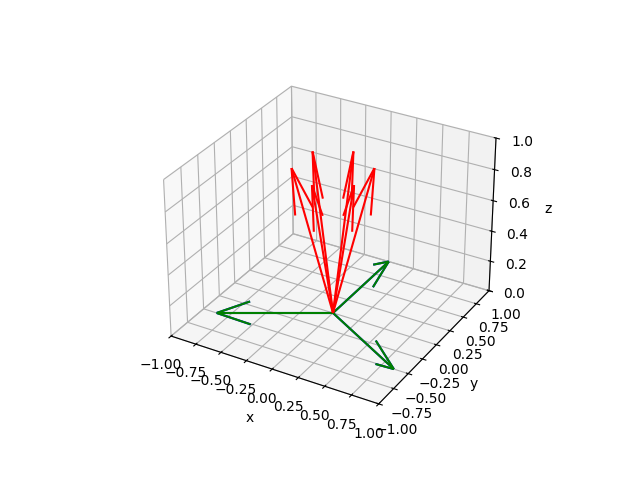

In [4]:

''' Checking slip systems'''

ax = plt.figure().add_subplot(projection='3d')
ax.quiver(o[pri][:,0],o[pri][:,1],o[pri][:,2],s[pri][:,0],s[pri][:,1],s[pri][:,2],
          color='blue')
ax.quiver(o[bas][:,0],o[bas][:,1],o[bas][:,2],s[bas][:,0],s[bas][:,1],s[bas][:,2],
          color='green')
ax.quiver(o[pyr][:,0],o[pyr][:,1],o[pyr][:,2],s[pyr][:,0],s[pyr][:,1],s[pyr][:,2],
          color='red')

ax.set_xlim((-1,1))
ax.set_ylim((-1,1))
ax.set_zlim((-0,1))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [5]:
'''Defining functions'''
# slip plane normal vectors for each slip system (3x prismatic, 3x basal, 6x pyramidal)
n = np.array([
    [1.0, 0.0, 0.0],
    [0.5, 0.866025, 0.0],
    [-0.5, 0.866025, 0.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.0, 0.0, 1.0],
    [0.846046, 0.0, 0.53311],
    [0.423023, 0.732697, 0.53311],
    [-0.423023, 0.732697, 0.53311],
    [-0.846046, 0.0, 0.53311],
    [-0.423023, -0.732697, 0.53311],
    [0.423023, -0.732697, 0.53311]])

# slip direction vectors for each slip system (3x prismatic, 3x basal, 6x pyramidal)
s = np.array([
    [0.0, 1.0, 0.0],
    [0.866025, -0.5, 0.0],
    [-0.866025, -0.5, 0.0],
    [0.866025, -0.5, 0.0],
    [0.0, 1.0, 0.0],
    [-0.866025, -0.5, 0.0],
    [0.296076, -0.170939, 0.939744],
    [0.296076, 0.170939, 0.939744],
    [0.0, 0.341879, 0.939744],
    [-0.296076, 0.170939, 0.939744],
    [-0.296076, -0.170939, 0.939744],
    [0.0, -0.341879, 0.939744]])

# only including prismatic and basal slip...
n = n[np.logical_or(slip_family=='Prismatic',slip_family=='Basal')]
s = s[np.logical_or(slip_family=='Prismatic',slip_family=='Basal')]

angles = np.arange(0,360,60) 
rots_c = R.from_euler('z',angles,degrees=True) # 6 rotations about c axis TODO(check this)
inv = R.from_quat([0,0,0,-1])
SYMS = list(rots_c) + [inv*r for r in rots_c] # full 12 operations including inverse

def misori(r1,r2):
    '''Calculates misorientation angle between two HCP orientations.'''
    delta = r2*r1.inv()
    mis_list = [(sym*delta).magnitude() for sym in SYMS]
    return min(mis_list)


def p(dE,T):
    '''Probability of swap using Metropolis probability function.'''
    if dE <= 0: # downhill: always accept
        return 1.0

    if T == 0: # uphill at T=0: never accept (DONT NEED SINCE T!=0)
        return 0.0

    x = dE / T
    if x > 700: # np.exp(700) is near overflow for float64
        return 0.0

    return np.exp(-x)


def neighbour_table(N):
    '''Creates a table of neighbours for each node.'''
    # set offsets as up/down/left/right/front/back
    offsets = [[0,0,1],[0,0,-1],[1,0,0],[-1,0,0],[0,1,0],[0,-1,0]]
    idx = np.arange(N**3).reshape((N,N,N)) # node indices arranged into a cube
    nbrs = [[] for i in range(N**3)]
    for x in range(N):
        for y in range(N):
            for z in range(N):
                here = idx[x,y,z]
                for dx,dy,dz in offsets:
                    i,j,k = x+dx, y+dy, z+dz
                    if 0<=i<N and 0<=j<N and 0<=k<N: # check out of bounds
                        nbrs[here].append(idx[i,j,k]) # append valid neighbour ids
    return [np.array(n,dtype=np.int32) for n in nbrs]


def local_misorientation(oris, node, nbrs):
    '''
    Calculates the total misorientation angle in radians from a node to all its neighbours.
    Inputs:
        - oris: list of scipy orientation objects
        - node: index of node
        - nbrs: list of neighbours indices
    Output:
        - Sum of misorientation angles (rad)
    '''
    r1 = oris[node] 
    misori_sum = 0
    for nb in nbrs[node]: # loop through each neighbour, add misorientation
        r2 = oris[nb]
        misori_sum += misori(r1,r2)
    
    return misori_sum


def global_misorientation(oris, nbrs):
    '''
    Calculates the global energy. Run once before annealing loop.
    Inputs:
        - oris: list of scipy orientation objects
        - nbrs: list of neighbour indices for each node
    Outputs:
        - Sum of all misorientation angles (rad)
    '''
    global_sum = 0
    for node in range(len(oris)):
        global_sum += local_misorientation(oris, node, nbrs)
    
    return global_sum/2 # correct for double up on each neighbour pair

def m_prime(r1, r2, n, s):
    '''
    Calculate the Luster-Morris parameter m' between two orientations, given a list of slip systems.
    Inputs:
        - r1: orientation A
        - r2: orientation B
        - n: array of normal vectors for each slip system
        - s: array of direction vectors for each slip system
    Outputs:
        - 
    m' = (nA.nB)(sA.sB), where n and s are unit normal and direction vectors

    '''
    mPrimes = []
    nAs = r1.apply(n)
    sAs = r1.apply(s)
    nBs = r2.apply(n)
    sBs = r2.apply(s)

    for a in range(len(n)): # needs to be a better way of writing this...
        for b in range(len(n)):
            mPrime = np.dot(nAs[a],nBs[b]) * np.dot(sAs[a],sBs[b])
            mPrimes.append(mPrime)
    
    return max(mPrimes)

def local_mPrime(oris, node, nbrs):
    '''
    Calculates the sum of m' values across all of a node's neighbours.
    Inputs:
        - oris: list of all scipy orientation objects
        - node: index of node
        - nbrs: list of neighbours indices
    Outputs:
        - Sum of m' values
    '''
    r1 = oris[node]
    mPrime_sum = 0
    for nb in nbrs[node]:
        # for each neighbour, loop through ALL pairs of slip systems.
        r2 = oris[nb] # retrives orientation object for neighbour
        mPrime_sum += m_prime(r1, r2, n, s)

    return mPrime_sum



def global_mPrime(oris, nbrs):
    global_sum = 0
    for node in range(len(oris)):
        global_sum += local_mPrime(oris,node,nbrs)
    
    return global_sum/2 # correct for double up on each neighbour pair





In [ ]:
def anneal(N, steps=10_000, maximise=False, seed=42, energy_function='mPrime'):
    '''
    **Performs a simulated anneal on a orientations of a microstructure.**

    ## Inputs
    - N: number of nodes per dimension. Total number will be N**3
    - steps: number of steps (swaps) performed by the algorithm
    - maximise: maximise or minimise the energy function
    - seed: seed for random generators
    - energy_function: 
        - 'mPrime' = sum of m' values with neighbours
        - 'misorientation' = sum of misorientation angles

    ## Returns
    - Final state (list of N**3 orientations reshaped to (N,N,N))
    - Steps vector
    - Energy vector
    
    '''
    # Assumes n and s are already defined as the list of slip normals and directions

    # ---------- Defining Parameters ----------
    if energy_function=='mPrime':
        # T0 = 1.5 based on 80% acceptance
        T0 = 3
    elif energy_function=='misorientation':
        # T0 = 12 based on 80% acceptance
        T0 = 12
    
    Tf = 0.001 * T0 # near final temperature, metropolis probability of uphill is low.
    alpha = (Tf/T0)**(1/steps)

    T = T0
    oris = R.random(N**3,rng=seed)
    nbrs = neighbour_table(N)
    rng = np.random.default_rng(seed)
    E_history = np.empty(steps,dtype=float)
    T_history = np.empty(steps,dtype=float)
    dE_history = np.empty(steps,dtype=float)
    P_history = np.empty(steps,dtype=float)


    if energy_function=='mPrime':
        E_total = global_mPrime(oris,nbrs)
    elif energy_function=='misorientation':
        E_total = global_misorientation(oris,nbrs)
    
    oris_initial = oris

    # main anneal loop
    for step in range(steps):
        a = rng.integers(0,N**3) # choose a random node
        b = rng.choice(nbrs[a]) # choose one of its neighbours
        

        if energy_function=='mPrime':
            Ea1 = local_mPrime(oris,a,nbrs)
            Eb1 = local_mPrime(oris,b,nbrs)
            oris[[a,b]] = oris[[b,a]] # swap
            Ea2 = local_mPrime(oris,a,nbrs)
            Eb2 = local_mPrime(oris,b,nbrs)
            dE = (Ea2+Eb2)-(Ea1+Eb1) # neighbour boundary double up cancels out


        if energy_function=='misorientation':
            Ea1 = local_misorientation(oris,a,nbrs)
            Eb1 = local_misorientation(oris,b,nbrs)
            oris[[a,b]] = oris[[b,a]] # swap
            Ea2 = local_misorientation(oris,a,nbrs)
            Eb2 = local_misorientation(oris,b,nbrs)
            dE = (Ea2+Eb2)-(Ea1+Eb1)

        if maximise:
            dE = -dE
        
        if rng.random() < p(dE,T): # accept a swap based on metropolis algorithm
            if maximise:
                E_total += -dE
            else:
                E_total += dE
        else:
            oris[[a,b]] = oris[[b,a]] # revert the swap

        E_history[step] = E_total
        T_history[step] = T
        dE_history[step] = dE
        P_history[step] = p(dE,T)
        T *= alpha

    steps_vector = np.arange(0,steps)
    
    return oris, steps_vector, E_history, T_history, dE_history, P_history, oris_initial

In [7]:
a = R.random()
b = a

a = R.random()
print(a.magnitude())

2.618572310058218


In [ ]:
N = 10, steps = 30000
oris, steps_vector, E_history, T_history, dE_history, P_history, oris_initial = anneal(5,5000,seed=1)
oris_max, steps_vector_max, E_history_max, T_history_max, dE_history_max, P_history_max, oris_initial_max = anneal(5,5000, maximise=True, seed=1)
# N=5 with 10,000 steps takes 10.8 seconds


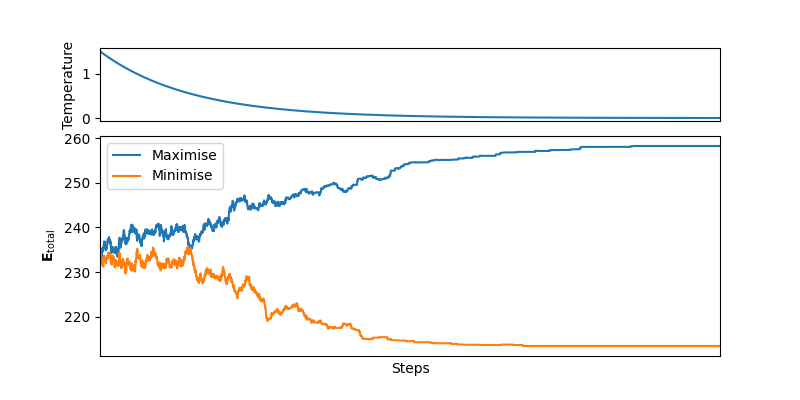

In [24]:
mosaic = [['Temp'],
          ['Energy']]

fig, ax = plt.subplot_mosaic(
    mosaic,
    figsize=(8,4),
    sharex=True,
    gridspec_kw={'height_ratios': [1, 3],
                 'hspace': 0.1},
    layout='tight'
)

# Plot as before
ax['Energy'].plot(steps_vector_max, E_history_max, label='Maximise')
ax['Energy'].plot(steps_vector, E_history, label='Minimise')
ax['Energy'].set_xlabel('Steps')
ax['Energy'].set_ylabel(r"$\mathbf{E}_{\mathrm{total}}$")
ax['Energy'].legend()
ax['Temp'].plot(steps_vector,T_history)

# Top plot tweaks
ax['Temp'].set_ylabel('Temperature')
# ax['Temp'].tick_params(labelbottom=False)
ax['Temp'].set_xticks([])

# All x‐limits
for name in ax:
    ax[name].set_xlim(0, max(steps_vector))

plt.show()

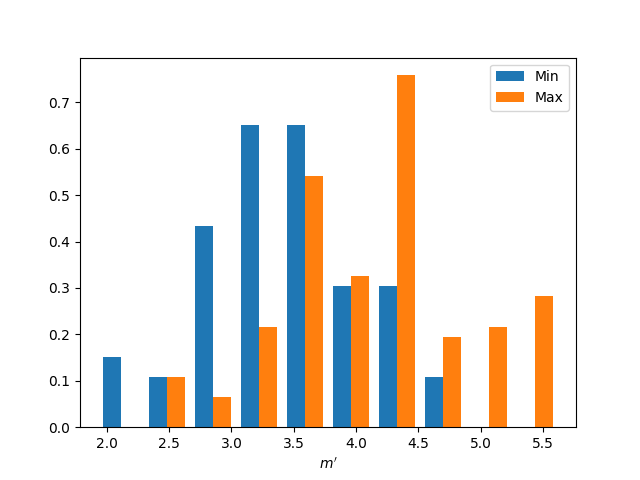

In [ ]:
nbrs = neighbour_table(5)
mp_min = np.empty(len(oris))
mp_max = np.empty(len(oris_max))

for i in range(len(oris)):
    mp_min[i] = local_mPrime(oris,i,nbrs)
    mp_max[i] = local_mPrime(oris_max,i,nbrs)

mps = [np.transpose(mp_min), np.transpose(mp_max)]

fig,ax = plt.subplots()
ax.hist(mps, density=True, histtype='bar', label=['Min','Max'])
ax.legend()
ax.set_xlabel("$m'$")

plt.show()
    

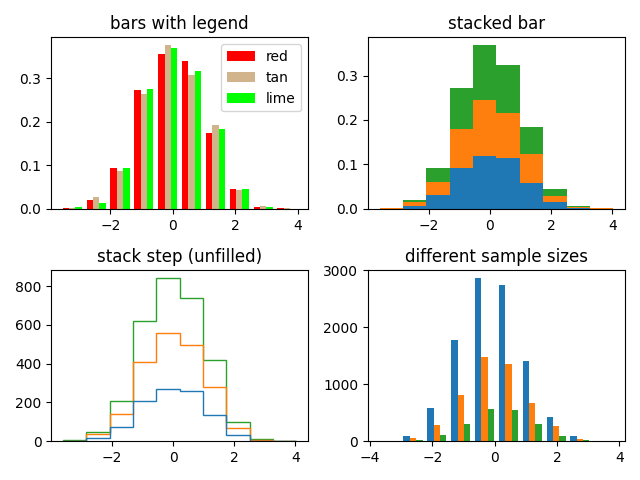

In [45]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(19680801)

n_bins = 10
x = np.random.randn(1000, 3)

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()

In [51]:
print(mps.shape)

(2, 125)


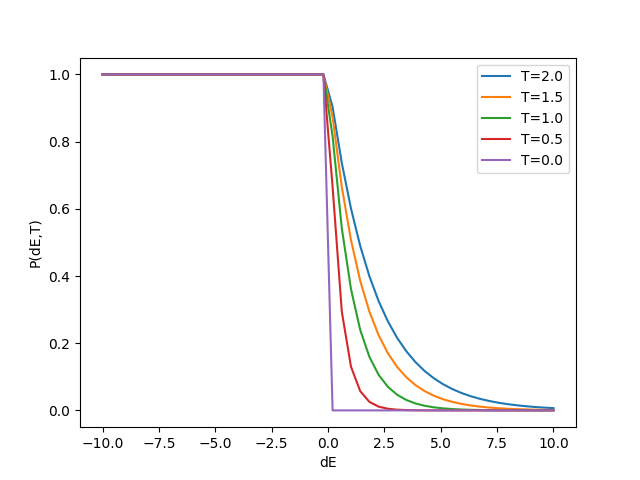

In [ ]:
# probabilitiy function

fig,ax = plt.subplots()

dE_list = np.linspace(-10,10)
T_list = np.arange(2,-0.5,-0.5)

for T in T_list:
    dE_list = -dE_list
    P = [p(dE,T) for dE in dE_list]
    ax.plot(dE_list, P, label=f'T={str(T)}')

ax.legend()
ax.set_xlabel('dE')
ax.set_ylabel('P(dE,T)')
plt.show()